In [2]:
import pandas as pd
from battleship.board import *
from battleship.spotter_model import Question, Answer, CodeSpotterModel, DirectSpotterModel, CODE_FAIL_STR
from battleship.prompting import SpotterPrompt
from tqdm import tqdm

In [3]:
def retrieve_context(question_id, round_data):
    question_history_data = round_data[round_data["questionID"] < question_id]
    question_data = round_data[round_data["questionID"] == question_id]

    #QUESTION AND ITS BOARD
    question_text = question_data[question_data["messageType"] == "question"]["messageText"].tolist()[0]
    #question_board_id = int(question_data[question_data["messageType"] == "question"]["board_id"].tolist()[0])
    question_board_id = question_data[question_data["messageType"] == "question"]["board_id"].tolist()[0]
    ground_truth_answer = question_data[question_data["messageType"] == "answer"]["messageText"].tolist()[0]

    #QUESTION HISTORY decision, question, answer, move
    #{"question":question, "code": q_ex.codestr, "answer": a_ex.text, "board_id": board}
    previous_decision_ids = sorted(list(set(question_history_data["questionID"].tolist())))

    examples = []
    for id in previous_decision_ids:
        decision, question, answer, move = None, None, None, None
        id_actions = question_history_data[question_history_data["questionID"] == id]
        try:
            decision = id_actions[id_actions["messageType"] == "decision"]["messageText"].tolist()[0]

            if decision == "question":
                question = id_actions[id_actions["messageType"] == "question"]["messageText"].tolist()[0]
                try:
                    answer = id_actions[id_actions["messageType"] == "answer"]["messageText"].tolist()[0]
                except:
                    answer = "Not answered"
            else:
                move = id_actions[id_actions["messageType"] == "move"]["messageText"].tolist()[0]
            
            dict_example = {"decision":decision, "question":question, "answer":answer, "move":move}
            examples.append(dict_example)
        except IndexError:
            if int(id) != 0:
                print(f"Error with decision id {id}")
    
    return {"context": {"text": question_text, "board_id": question_board_id, "true_answer": ground_truth_answer}, "history": examples}


In [4]:
stage_df = pd.read_csv("/home/ubuntu/repo_battleship/battleship/experiments/collaborative/data/battleship-final-data/stage.csv")
round_df = pd.read_csv("/home/ubuntu/repo_battleship/battleship/experiments/collaborative/data/battleship-final-data/round.csv")

board_ids = round_df[["id","board_id"]]

filtered_stage_df = stage_df[["roundID","index","questionID","messageText","messageType","occTiles"]]
df = filtered_stage_df.merge(board_ids, left_on="roundID", right_on="id", how="inner")
df = df.drop(columns="id")

round_index_max = df.groupby("roundID")["index"].max()
dirty_round_ids = round_index_max[round_index_max <= 10].index
df = df[~df["roundID"].isin(dirty_round_ids)]

rounds = list(set(df["roundID"].tolist()))

In [5]:
spotter_model = CodeSpotterModel(board_id="B01", board_experiment="collaborative_contexts", history=None, use_cache=True)

q = "Are there ships in the top-left quadrant of the board?"

question = Question(text=q)
model_answer = spotter_model.answer(question)
model_answer

Answer(text='Yes', code_question=None)

In [6]:
def benchmark_on_rounds(df, round_list, model, use_history=False, max_rounds=10, max_questions=10, use_cache=True):
    correct = []
    failed_cache_ids = []
    for round in round_list[:max_rounds]:
        round_data = df[df["roundID"] == round]
        question_ids = sorted(round_data[round_data["messageType"] == "question"]["questionID"].tolist())

        for question_id in tqdm(question_ids[:max_questions], desc=f"Round {str(round)}"):
            question_context = retrieve_context(question_id, round_data)

            examples = question_context["history"]
            question_board = question_context["context"]["board_id"]
            question_text = question_context["context"]["text"]
            ground_truth_answer = question_context["context"]["true_answer"]
            
            if use_history:
                spotter_model = model(board_id=question_board, board_experiment="collaborative_contexts", history=examples, use_cache=use_cache)
            else:
                spotter_model = model(board_id=question_board, board_experiment="collaborative_contexts", history=None, use_cache=use_cache)

            question = Question(text=question_text)
            model_answer = spotter_model.answer(question)

            if model_answer.text != CODE_FAIL_STR: 

                try:
                    lowercase_bool = model_answer.text.lower()
                except AttributeError:
                    print("Non-string answer:",model_answer.text)
                    failed_cache_ids.append([question.get_cache_key(question_board), (model_answer.text, ground_truth_answer)])
                    continue

                correct_bool = lowercase_bool == ground_truth_answer

                if not correct_bool:
                    failed_cache_ids.append([question.get_cache_key(question_board), (lowercase_bool, ground_truth_answer)])
                
                correct.append(correct_bool)
            else:
                pass
    return sum(correct)/len(correct), failed_cache_ids

In [7]:
code_spotter_accuracy = benchmark_on_rounds(df, rounds, CodeSpotterModel, True, 130, 20, True)
code_spotter_accuracy[1]

Round 01JJ8A81MHQ70CR2SHNX5TTRDS: 100%|██████████| 3/3 [00:00<00:00, 139.50it/s]


Error with decision id 33.0


Round 01JJ8784KNNQ05V5BQ2Q033G45:   0%|          | 0/2 [00:00<?, ?it/s]

Error with decision id 1.0


Round 01JJ8784KNNQ05V5BQ2Q033G45:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it]

Error with decision id 1.0


Round 01JJZ4ZY4T4E01TV5H8BAAPAF3:   0%|          | 0/2 [00:00<?, ?it/s]

Error with decision id 1.0


Round 01JJZ4ZY4T4E01TV5H8BAAPAF3:  50%|█████     | 1/2 [00:01<00:01,  1.21s/it]

Error with decision id 1.0


Round 01JDN0VKDN87TVWWHBYDJBY8NR: 100%|██████████| 8/8 [00:00<00:00, 65.35it/s]


Error with decision id 13.0
Error with decision id 13.0
Error with decision id 19.0
Error with decision id 13.0
Error with decision id 19.0
Error with decision id 13.0
Error with decision id 19.0
Error with decision id 13.0
Error with decision id 19.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  47%|████▋     | 7/15 [00:10<00:08,  1.11s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  53%|█████▎    | 8/15 [00:14<00:13,  1.94s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  60%|██████    | 9/15 [00:15<00:11,  1.85s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  67%|██████▋   | 10/15 [00:23<00:17,  3.54s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  73%|███████▎  | 11/15 [00:24<00:11,  2.75s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  80%|████████  | 12/15 [00:26<00:07,  2.49s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  87%|████████▋ | 13/15 [00:27<00:04,  2.05s/it]

Error with decision id 29.0


Round 01JFK81ACYV27ND5DFEAC4M8V7:  93%|█████████▎| 14/15 [00:29<00:02,  2.10s/it]

Error with decision id 29.0


Round 01JJZ4PE7A3F1K85AZ7SK4AKBS: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]
Round 01JJ7ZYZFN900RDQZWZH824VR8: 0it [00:00, ?it/s]
Round 01JDN16ADZ0H3Q87MASTVBE64P: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]
Round 01JDN1CB96JFAQ5T3S7TEDKPF0: 0it [00:00, ?it/s]
Round 01JDN4BVCA333MJVYBCWFZDZ9S: 100%|██████████| 15/15 [00:00<00:00, 111.12it/s]
Round 01JJ7TE2E1Y0E8GAW6BAYZWX0B: 0it [00:00, ?it/s]
Round 01JJ5S78XB059RXW2T7E9E2MS2: 100%|██████████| 4/4 [00:00<00:00, 182.07it/s]
Round 01JJ7WBVVQCWRADB98H61R8F8C: 0it [00:00, ?it/s]
Round 01JJ2YJMHB6CMD8R0VCXNEV580: 100%|██████████| 6/6 [00:00<00:00, 178.22it/s]


Error with decision id 3.0
Error with decision id 3.0
Error with decision id 3.0
Error with decision id 3.0
Error with decision id 17.0
Error with decision id 21.0
Error with decision id 29.0
Error with decision id 33.0
Error with decision id 3.0
Error with decision id 17.0
Error with decision id 21.0
Error with decision id 29.0
Error with decision id 33.0


Round 01JJ2X6A4JR0KRNVJAHC4782KV: 100%|██████████| 13/13 [00:00<00:00, 77.37it/s]

Error with decision id 11.0
Error with decision id 11.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 45.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 45.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 45.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 45.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 45.0
Error with decision id 69.0
Error with decision id 73.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 45.0
Error with decision id 69.0
Error with decision id 73.0



Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:   0%|          | 0/15 [00:00<?, ?it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:   7%|▋         | 1/15 [00:00<00:11,  1.21it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  13%|█▎        | 2/15 [00:01<00:10,  1.20it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  20%|██        | 3/15 [00:02<00:09,  1.28it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  33%|███▎      | 5/15 [00:04<00:08,  1.18it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  40%|████      | 6/15 [00:05<00:09,  1.04s/it]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  53%|█████▎    | 8/15 [00:07<00:06,  1.09it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  60%|██████    | 9/15 [00:08<00:05,  1.10it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  67%|██████▋   | 10/15 [00:08<00:04,  1.15it/s]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  73%|███████▎  | 11/15 [00:10<00:04,  1.04s/it]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  80%|████████  | 12/15 [00:11<00:03,  1.12s/it]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  87%|████████▋ | 13/15 [00:13<00:02,  1.28s/it]

Error with decision id 19.0


Round 01JFFX0ZPTKKDP75FZ7NZZZMPT:  93%|█████████▎| 14/15 [00:14<00:01,  1.21s/it]

Error with decision id 19.0


Round 01JJ5SN0G4S5M9H2Q8AGX4R08G:   0%|          | 0/4 [00:00<?, ?it/s]

Error with decision id 1.0


Round 01JJ5SN0G4S5M9H2Q8AGX4R08G:  25%|██▌       | 1/4 [00:01<00:03,  1.18s/it]

Error with decision id 1.0


Round 01JJ5SN0G4S5M9H2Q8AGX4R08G:  50%|█████     | 2/4 [00:02<00:01,  1.02it/s]

Error with decision id 1.0


Round 01JJ5SN0G4S5M9H2Q8AGX4R08G:  75%|███████▌  | 3/4 [00:06<00:02,  2.45s/it]

Non-string answer: (array([1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7]), array([4, 3, 4, 3, 4, 2, 3, 1, 2, 1, 2, 1]))
Error with decision id 1.0
Error with decision id 15.0


Round 01JHZRQTG7HBZG89XGH9A9BV13: 100%|██████████| 12/12 [00:13<00:00,  1.08s/it]
Round 01JJ7Z6B7ZA1JYN6T3F178W8EK: 0it [00:00, ?it/s]
Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:   0%|          | 0/12 [00:00<?, ?it/s]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:   8%|▊         | 1/12 [00:01<00:14,  1.29s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  17%|█▋        | 2/12 [00:02<00:14,  1.49s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  25%|██▌       | 3/12 [00:04<00:11,  1.33s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  33%|███▎      | 4/12 [00:06<00:13,  1.66s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  42%|████▏     | 5/12 [00:07<00:09,  1.35s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  50%|█████     | 6/12 [00:07<00:07,  1.18s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  58%|█████▊    | 7/12 [00:08<00:05,  1.07s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  67%|██████▋   | 8/12 [00:11<00:06,  1.68s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  75%|███████▌  | 9/12 [00:13<00:05,  1.70s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  83%|████████▎ | 10/12 [00:14<00:03,  1.58s/it]

Error with decision id 1.0


Round 01JJ7ZHH1R8Q45G4ZEDEPVHDDX:  92%|█████████▏| 11/12 [00:15<00:01,  1.40s/it]

Error with decision id 1.0


Round 01JJ8BWJ62G8T856ZDC41QG1W0: 100%|██████████| 5/5 [00:00<00:00, 96.97it/s]


Error with decision id 9.0
Error with decision id 13.0
Error with decision id 9.0
Error with decision id 13.0
Error with decision id 38.0
Error with decision id 9.0
Error with decision id 13.0
Error with decision id 38.0
Error with decision id 64.0
Error with decision id 68.0
Error with decision id 72.0
Error with decision id 74.0


Round 01JJ7XE7JD29BEKTD8K2YMZW8B: 100%|██████████| 4/4 [00:00<00:00, 207.86it/s]


Error with decision id 15.0
Error with decision id 17.0


Round 01JJ2W51271SMCJRRM95SDDQZ4: 100%|██████████| 14/14 [00:00<00:00, 75.75it/s]


Error with decision id 5.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 37.0
Error with decision id 41.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 37.0
Error with decision id 41.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 37.0
Error with decision id 41.0
Error with decision id 49.0
Error with decision id 5.0
Error with decision id 11.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 37.0
Error with decision id 41.0
Error with decision id 49.0
Error with decision id 57.0
Error with decision id 5.0
Error with decision id 11.0
E

Round 01JJ7XW3K20BBA34EZEC8GPDHK: 0it [00:00, ?it/s]
Round 01JJ8BHRK7THZ5A14XESXTCCJZ:  75%|███████▌  | 3/4 [00:05<00:01,  1.66s/it]

Error with decision id 32.0


Round 01JJWY336N8QXRJEKFFT32YH1F: 100%|██████████| 15/15 [00:00<00:00, 78.46it/s] 


Error with decision id 8.0
Error with decision id 9.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 42.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 42.0
Error with decision id 62.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 42.0
Error with decision id 62.0
Error with decision id 8.0
Error with decision id 9.0
Error with decision id 26.0
Error with decision id 42.0
Error with decision id 62.0
Error with decision id 8.0
Error with decision id 9.0
Error with dec

Round 01JJ86CRBWTE865G946G1T0YW4: 100%|██████████| 5/5 [00:00<00:00, 103.59it/s]


Error with decision id 50.0


Round 01JDN32SA1YJMXY3MYS8TRHFEF: 100%|██████████| 15/15 [00:00<00:00, 107.79it/s]
Round 01JDN6RYBB68D47N6DGKE8PS32: 0it [00:00, ?it/s]
Round 01JJX055A8B35MMQX8K0A5CY5J: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
Round 01JDN1EH9K7STYW5EXZAQ3PXQ3: 0it [00:00, ?it/s]
Round 01JJWZGGF9SQ6RKQ80Z1KY7MGA: 100%|██████████| 13/13 [00:00<00:00, 114.78it/s]


Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0


Round 01JJ7VQBWS3TASREX20G075V7J: 0it [00:00, ?it/s]
Round 01JG2NFKRH0TAX71E1GTY1QXKV:   0%|          | 0/13 [00:00<?, ?it/s]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:   8%|▊         | 1/13 [00:02<00:26,  2.25s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  15%|█▌        | 2/13 [00:03<00:15,  1.39s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  23%|██▎       | 3/13 [00:03<00:10,  1.07s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  31%|███       | 4/13 [00:05<00:11,  1.28s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  38%|███▊      | 5/13 [00:06<00:09,  1.24s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  46%|████▌     | 6/13 [00:07<00:07,  1.07s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  54%|█████▍    | 7/13 [00:08<00:06,  1.06s/it]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  62%|██████▏   | 8/13 [00:08<00:04,  1.10it/s]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  69%|██████▉   | 9/13 [00:09<00:03,  1.05it/s]

Error with decision id 1.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  77%|███████▋  | 10/13 [00:10<00:02,  1.06it/s]

Error with decision id 1.0
Error with decision id 41.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  85%|████████▍ | 11/13 [00:11<00:01,  1.09it/s]

Error with decision id 1.0
Error with decision id 41.0


Round 01JG2NFKRH0TAX71E1GTY1QXKV:  92%|█████████▏| 12/13 [00:14<00:01,  1.43s/it]

Error with decision id 1.0
Error with decision id 41.0


Round 01JJ86ZX7M8HTZXBXYGKADH548: 100%|██████████| 4/4 [00:00<00:00, 89.00it/s]


Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0


Round 01JFK5BPBG2G1X2CQ081PCBPQD: 100%|██████████| 9/9 [00:00<00:00, 76.15it/s]


Error with decision id 34.0
Error with decision id 34.0
Error with decision id 34.0
Error with decision id 34.0


Round 01JJ7S3X6ZGPCQKZDGX482QZR6: 100%|██████████| 15/15 [00:00<00:00, 152.55it/s]


Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0
Error with decision id 8.0


Round 01JDN2F3NG0TPHBF7CQ4BSEJZ5:  50%|█████     | 3/6 [00:02<00:02,  1.12it/s]

Error with decision id 28.0


Round 01JDN2F3NG0TPHBF7CQ4BSEJZ5:  67%|██████▋   | 4/6 [00:03<00:01,  1.24it/s]

Error with decision id 28.0


Round 01JDN2F3NG0TPHBF7CQ4BSEJZ5:  83%|████████▎ | 5/6 [00:04<00:00,  1.02it/s]

Error with decision id 28.0


Round 01JHZT0YWR2THGA16TDW5MZW3A: 100%|██████████| 8/8 [00:00<00:00, 124.61it/s]


Error with decision id 7.0
Error with decision id 7.0
Error with decision id 15.0
Error with decision id 7.0
Error with decision id 15.0
Error with decision id 7.0
Error with decision id 15.0
Error with decision id 7.0
Error with decision id 15.0
Error with decision id 7.0
Error with decision id 15.0
Error with decision id 44.0


Round 01JJ5VFZNHVP2N8TKBYZ2CA0V4:   0%|          | 0/2 [00:00<?, ?it/s]

Error with decision id 1.0


Round 01JJ5VFZNHVP2N8TKBYZ2CA0V4: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Error with decision id 1.0


Round 01JG2SHVBERQWMDW62J9TAZPKQ: 100%|██████████| 8/8 [00:00<00:00, 85.98it/s]


Error with decision id 5.0
Error with decision id 19.0
Error with decision id 5.0
Error with decision id 19.0
Error with decision id 25.0
Error with decision id 5.0
Error with decision id 19.0
Error with decision id 25.0
Error with decision id 5.0
Error with decision id 19.0
Error with decision id 25.0
Error with decision id 48.0
Error with decision id 50.0
Error with decision id 5.0
Error with decision id 19.0
Error with decision id 25.0
Error with decision id 48.0
Error with decision id 50.0
Error with decision id 5.0
Error with decision id 19.0
Error with decision id 25.0
Error with decision id 48.0
Error with decision id 50.0


Round 01JJ2VDZ592VNHB16M2JX62Z0E:  30%|███       | 3/10 [00:04<00:11,  1.68s/it]

Error with decision id 23.0
Error with decision id 25.0


Round 01JJ2VDZ592VNHB16M2JX62Z0E:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Error with decision id 23.0
Error with decision id 25.0
Error with decision id 31.0


Round 01JJ2VDZ592VNHB16M2JX62Z0E:  50%|█████     | 5/10 [00:07<00:08,  1.75s/it]

Error with decision id 23.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 40.0


Round 01JJ2VDZ592VNHB16M2JX62Z0E:  60%|██████    | 6/10 [00:08<00:05,  1.46s/it]

Error with decision id 23.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 40.0
Error with decision id 23.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 40.0


Round 01JJ2VDZ592VNHB16M2JX62Z0E:  80%|████████  | 8/10 [00:09<00:01,  1.07it/s]

Error with decision id 23.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 40.0


Round 01JJ2VDZ592VNHB16M2JX62Z0E:  90%|█████████ | 9/10 [00:10<00:00,  1.03it/s]

Error with decision id 23.0
Error with decision id 25.0
Error with decision id 31.0
Error with decision id 40.0


Round 01JG2QVWFWXX2WAQ9HQZ3E45SP: 100%|██████████| 9/9 [00:00<00:00, 55.62it/s]


Error with decision id 3.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 47.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 47.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 47.0
Error with decision id 71.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 47.0
Error with decision id 71.0
Error with decision id 3.0
Error with decision id 23.0
Error with decision id 47.0
Error with decision id 71.0
Error with decision id 79.0


Round 01JJ8AKZ44QRB2DXDDA69ACX8D: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
Round 01JJ80BNJMG47XQB9ZG6MA027P: 0it [00:00, ?it/s]
Round 01JJWX7FWF7QRJNFRX4EWKQ561: 100%|██████████| 14/14 [00:00<00:00, 97.01it/s] 
Round 01JJZ4831A7NHAYSJ8JQJH9HDA: 0it [00:00, ?it/s]
Round 01JDN23EQZ0GZDVVGRB9MDBH3A: 100%|██████████| 12/12 [00:00<00:00, 136.31it/s]


Error with decision id 40.0
Error with decision id 40.0
Error with decision id 40.0
Error with decision id 40.0


Round 01JFK7GB9BAC1GRM4C43AJXQ2Z:  50%|█████     | 2/4 [00:05<00:06,  3.27s/it]

Error with decision id 26.0


Round 01JFK7GB9BAC1GRM4C43AJXQ2Z:  75%|███████▌  | 3/4 [00:06<00:02,  2.09s/it]

Error with decision id 26.0


Round 01JJX1ZSD0A5RVJJRNZK33CXFH: 100%|██████████| 14/14 [00:00<00:00, 78.02it/s]


Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0
Error with decision id 1.0


Round 01JJ2Y47MB77KFFGWZ5N00KGEW:   0%|          | 0/4 [00:00<?, ?it/s]

Error with decision id 3.0
Error with decision id 3.0
Error with decision id 3.0
Error with decision id 3.0
Error with decision id 24.0
Error with decision id 34.0
Error with decision id 40.0
Error with decision id 50.0
Error with decision id 52.0


Round 01JFK8ZTQK048Q68G9PBXZ7B46:  50%|█████     | 1/2 [00:02<00:02,  2.39s/it]

Error with decision id 26.0
Error with decision id 28.0


Round 01JFK8ZTQK048Q68G9PBXZ7B46: 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]


[['is_the_orange_ship_horizontal_B11', ('yes', 'no')],
 ['are_there_some_on_the_right_side?_B11', ('yes', 'no')],
 ['are_there_any_ships_or_part_of_any_ships_in_row_a?_B13', ('yes', 'no')],
 ['does_that_ship,_the_red_one,_border_any_other_ships?_B13', ('no', 'yes')],
 ['is_the_bordering_ship_below_it?_B13', ('no', 'yes')],
 ['do_any_of_the_remaining_two_ships_border_the_two_destroyed_ships?_B13',
  ('yes', 'no')],
 ['are_either_of_the_remaining_ships_in_columns_4_and_5?_B13', ('yes', 'no')],
 ['is_any_part_of_the_remaining_ship_in_row_h?_B13', ('no', 'yes')],
 ['would_h1_be_a_hit?_B13', ('no', 'yes')],
 ['is_the_rest_of_the_green_ship_on_b5?_B13', ('yes', 'no')],
 ['up_for_yellow?_B18', ('no', 'yes')],
 ['should_i_click_top_half_of_the_board?_B18', ('yes', 'no')],
 ['is_green_horizontal?_B18', ('yes', 'no')],
 ['click_up?_B18', ('yes', 'no')],
 ['is_the_green_ship_horizontal?_B16', ('yes', 'no')],
 ['is_there_a_piece_of_the_red_ship_in_letter_c?_B16', ('no', 'yes')],
 ['is_the_green_sh

In [8]:
code_spotter_accuracy[0]

0.6464250734573947

Question:  should i go top? 
Board:  1


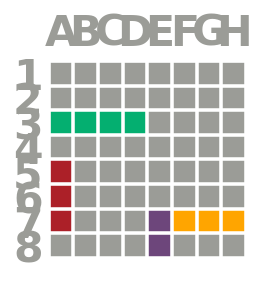

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'No' if np.any(board[0, :] != 'W') else 'Yes'
----------------------------------------
Question:  is purple ship horizontal? 
Board:  1


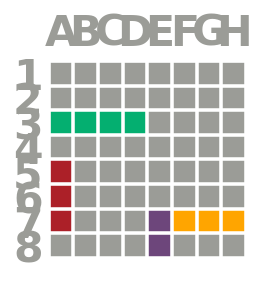

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(np.all(board == 'P', axis=1)) else 'No'
----------------------------------------
Question:  ouch is red ship horizontal? 
Board:  1


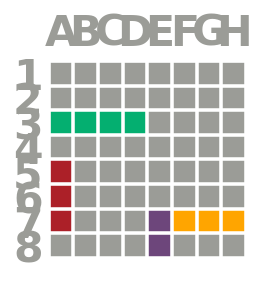

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(np.all(board == 'R', axis=1)) else 'No'
----------------------------------------
Question:  should i go up? 
Board:  1


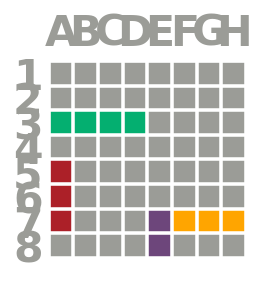

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'No'
----------------------------------------
Question:  there are 4 quadrants in the graph, are there any ships in the top left quadrant? 
Board:  5


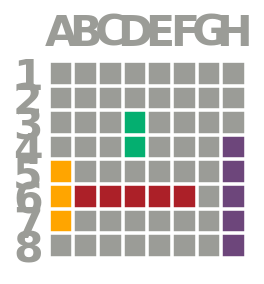

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:4, :4] != 'W') else 'No'
----------------------------------------
Question:  is there more than 1 ship in the top left quadrant? 
Board:  5


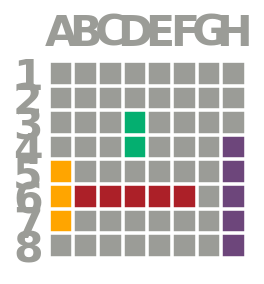

LLM Response:  no
Human Response:  no
def answer(board):
    top_left_quadrant = board[:4, :4]
    unique_ships = np.unique(top_left_quadrant[top_left_quadrant != 'W'])
    return 'Yes' if len(unique_ships) > 1 else 'No'
----------------------------------------
Question:  is the ship in the top left quadrant vertical? 
Board:  5


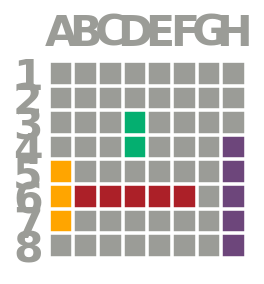

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:4, 0:4] == 'G') else 'No'
----------------------------------------
Question:  are there any ships in the bottom left quadrant? 
Board:  5


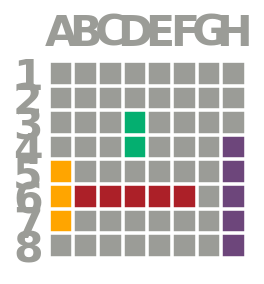

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[4:, :4] != 'W') else 'No'
----------------------------------------
Question:  is there more than 1 ship in the bottom left quadrant? 
Board:  5


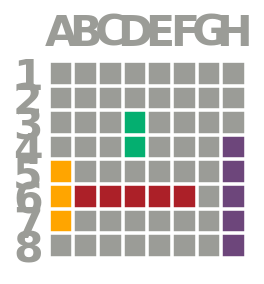

LLM Response:  yes
Human Response:  yes
def answer(board):
    bottom_left_quadrant = board[4:, :4]
    unique_ships = np.unique(bottom_left_quadrant[bottom_left_quadrant != 'W'])
    return 'Yes' if len(unique_ships) > 1 else 'No'
----------------------------------------
Question:  are the ships both horizontal and vertical in the bottom left quadrant? 
Board:  5


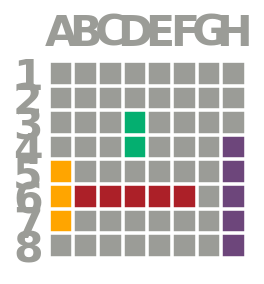

LLM Response:  no
Human Response:  yes
def answer(board):
    bottom_left_quadrant = board[4:8, 0:4]
    horizontal = np.any(np.all(bottom_left_quadrant == bottom_left_quadrant[:, 0][:, None], axis=1))
    vertical = np.any(np.all(bottom_left_quadrant == bottom_left_quadrant[0, :][None, :], axis=0))
    return 'Yes' if horizontal and vertical else 'No'
----------------------------------------
Question:  are there any other ships in the bottom left quadrant? 
Board:  5


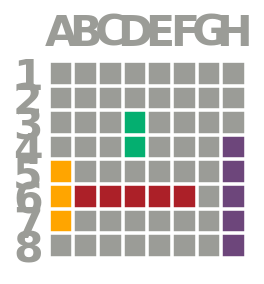

LLM Response:  no
Human Response:  no
def answer(board):
    bottom_left_quadrant = board[4:8, 0:4]
    unique_ships = np.unique(bottom_left_quadrant)
    ships = [s for s in unique_ships if s in ['G', 'R', 'P', 'O']]
    return 'Yes' if len(ships) > 2 else 'No'
----------------------------------------
Question:  are there any ships in the top right quadrant? 
Board:  5


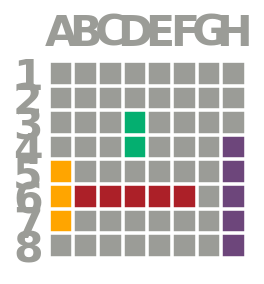

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:4, 4:] != 'W') else 'No'
----------------------------------------
Question:  is the last remaining ship in the bottom right quadrant? 
Board:  5


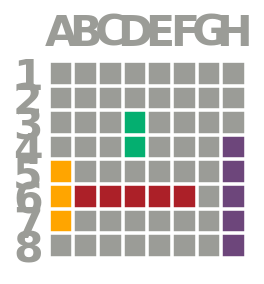

LLM Response:  yes
Human Response:  yes
def answer(board):
    bottom_right_quadrant = board[4:8, 4:8]
    return 'Yes' if np.any(bottom_right_quadrant == 'P') else 'No'
----------------------------------------
Question:  is the last ship vertical? 
Board:  5


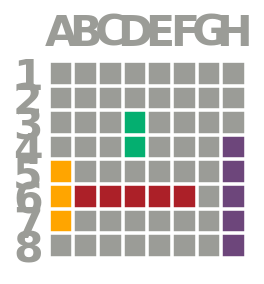

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[4:8, 7] == 'P') else 'No'
----------------------------------------
Question:  are there any ships on column 1? 
Board:  2


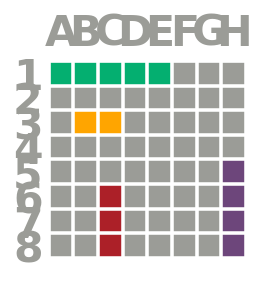

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 0] != 'W') else 'No'
----------------------------------------
Question:  yes if it is a-d, no if e-h 
Board:  2


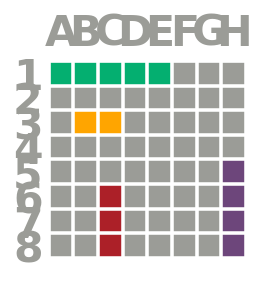

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, :4] != 'W') else 'No'
----------------------------------------
Question:  is there a ship on column 2? 
Board:  2


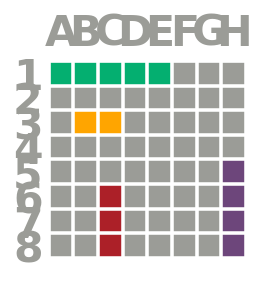

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 1] != 'W') else 'No'
----------------------------------------
Question:  is there a ship on row a? 
Board:  2


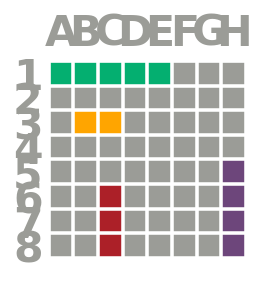

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0] != 'W') else 'No'
----------------------------------------
Question:  is there a ship on column 8? 
Board:  2


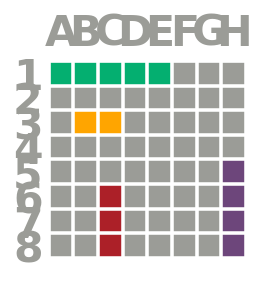

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 7] != 'W') else 'No'
----------------------------------------
Question:  is the 2 box ship horizontal (hit yes) or vertical (hit no) 
Board:  2


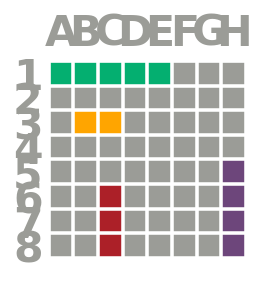

LLM Response:  yes
Human Response:  yes
def answer(board):
    # Find the coordinates of the 'O' ship
    coords = np.argwhere(board == 'O')
    # Check if the ship is horizontal or vertical
    if len(coords) == 2 and coords[0][0] == coords[1][0]:
        return 'Yes'
    else:
        return 'No'
----------------------------------------
Question:  is it on row for h (hit yes) or neither (hit no 
Board:  2


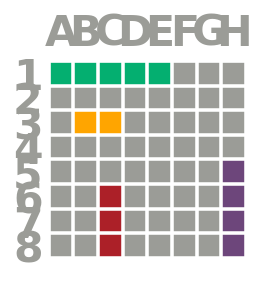

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[5] != 'W') or np.any(board[7] != 'W') else 'No'
----------------------------------------
Question:  is it on row d or e (yes), or neither (hit no) 
Board:  2


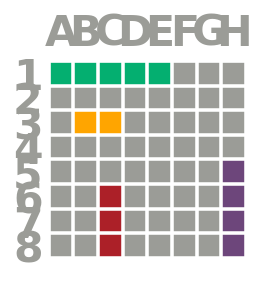

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[3:5] == 'O') else 'No'
----------------------------------------
Question:  is it on row b or c (hit yes), or row a (hit no) 
Board:  2


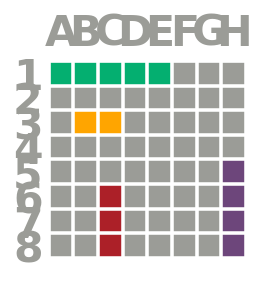

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'yes' if np.any(board[1:3] == 'O') else 'no'
----------------------------------------
Question:  is it row b (yes) or c (no) 
Board:  2


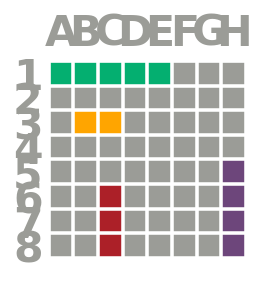

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if 'O' in board[2] else 'No'
----------------------------------------
Question:  skibidi toilet. are the ships populated on the top of the board? 
Board:  6


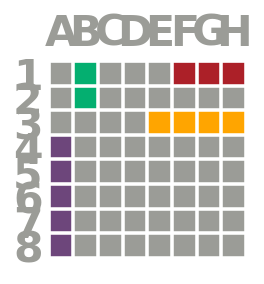

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:4, :] != 'W') else 'No'
----------------------------------------
Question:  through columns 1-4? 
Board:  6


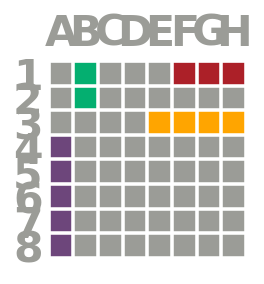

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, :4] != 'W') else 'No'
----------------------------------------
Question:  should i move up? 
Board:  6


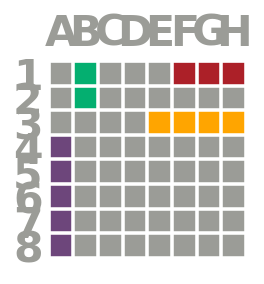

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'No'
----------------------------------------
Question:  do i move down? 
Board:  6


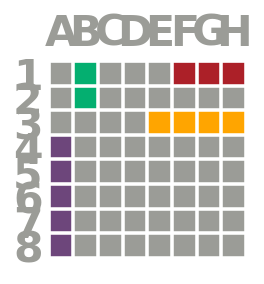

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if board[1, 1] == 'G' else 'No'
----------------------------------------
Question:  are the rest of the ships on columns 5-8? 
Board:  6


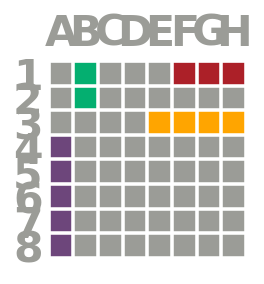

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 4:] != 'W') else 'No'
----------------------------------------
Question:  on the bottom? 
Board:  6


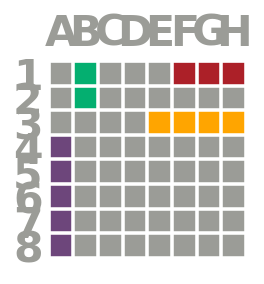

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[4:8, :] != 'W') else 'No'
----------------------------------------
Question:  should i move down? 
Board:  6


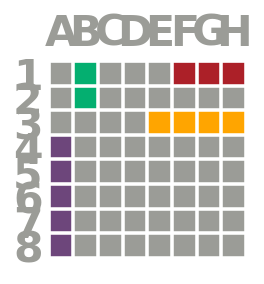

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[1:, 5:] != 'W') else 'No'
----------------------------------------
Question:  should i move right? 
Board:  6


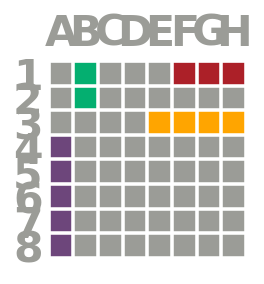

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:4, 5:8] != 'W') else 'No'
----------------------------------------
Question:  is the last ship on the bottom right of the board? 
Board:  6


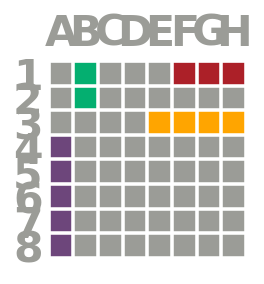

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[4:, 4:] == 'O') else 'No'
----------------------------------------
Question:  is the last ship on row e? 
Board:  6


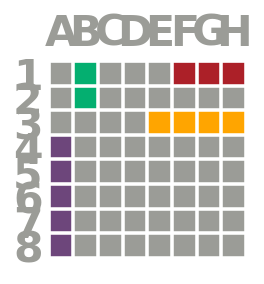

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if 'O' in board[4] else 'No'
----------------------------------------
Question:  is there any ships on rows a or b? 
Board:  4


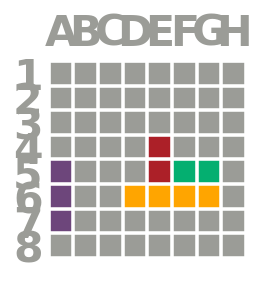

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[0:2] != 'W') else 'No'
----------------------------------------
Question:  yes if i fire vertical, no for horizontal 
Board:  6


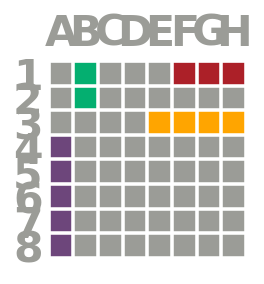

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if board[0, 1] == board[1, 1] else 'No'
----------------------------------------
Question:  yes if i fire on 8, no for 6 
Board:  6


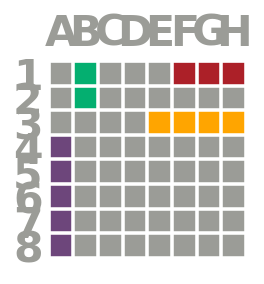

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if 'G' in board[7] or 'R' in board[7] or 'O' in board[7] or 'P' in board[7] else 'No'
----------------------------------------
Question:  any ships on column 1? 
Board:  6


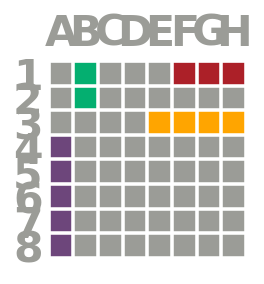

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 0] != 'W') else 'No'
----------------------------------------
Question:  yes for vertical, no for horizontal 
Board:  6


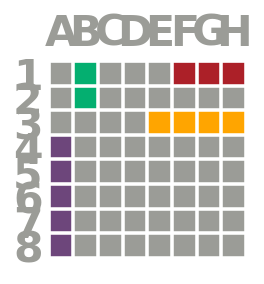

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 0] != 'W') else 'No'
----------------------------------------
Question:  yes for 1-d, no for e-h 
Board:  6


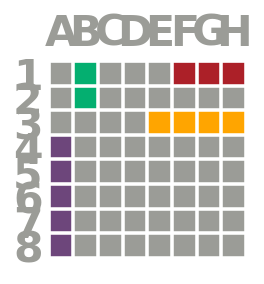

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if board[0, 3] in ['G', 'R', 'P', 'O'] else 'No'
----------------------------------------
Question:  yes for h, no for f 
Board:  6


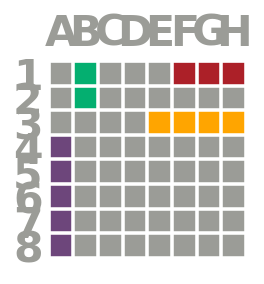

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if 'H' in board[:, 7] else 'No'
----------------------------------------
Question:  any ships row a or no? 
Board:  6


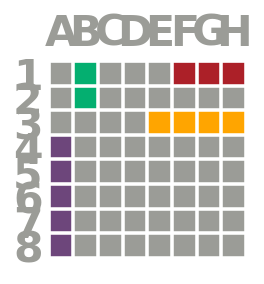

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0] != 'W') else 'No'
----------------------------------------
Question:  1-4 yes or 5-8 no 
Board:  6


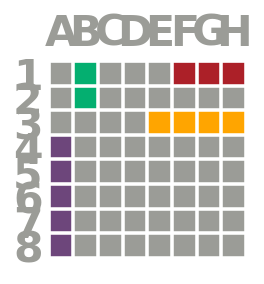

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'yes' if np.any(board[0:4, :] != 'W') else 'no'
----------------------------------------
Question:  5-6 yes 7-8 no 
Board:  6


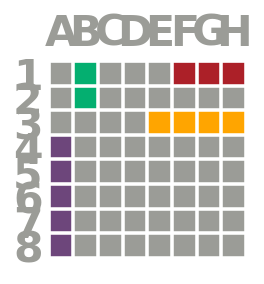

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[4:6] != 'W') else 'No'
----------------------------------------
Question:  7 yes 8 no 
Board:  6


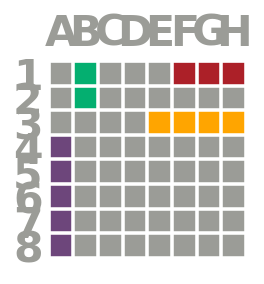

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[6] != 'W') else 'No'
----------------------------------------
Question:  sorry green and red overlapped, wanted you to hit both. ships in col1? 
Board:  5


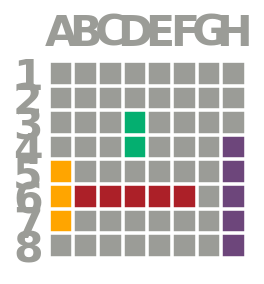

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 0] != 'W') else 'No'
----------------------------------------
Question:  woops. didn't see i finished orange. green horizontal? 
Board:  5


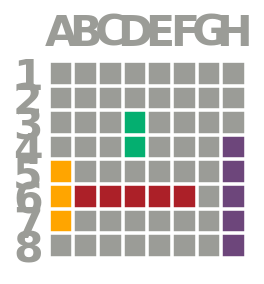

LLM Response:  no
Human Response:  yes
def answer(board):
    green_positions = np.argwhere(board == 'G')
    if len(green_positions) < 2:
        return 'No'
    rows = green_positions[:, 0]
    return 'Yes' if np.all(rows == rows[0]) else 'No'
----------------------------------------
Question:  should i fire up? 
Board:  5


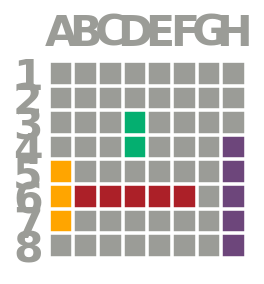

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board == 'W') else 'No'
----------------------------------------
Question:  sorry. wife dropped the spaghetti lol. fire up? 
Board:  5


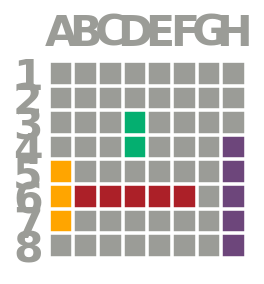

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:7, :] == 'P') else 'No'
----------------------------------------
Question:  is the red ship vertical? 
Board:  1


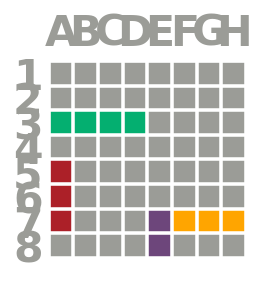

LLM Response:  yes
Human Response:  no
def answer(board):
    red_positions = np.argwhere(board == 'R')
    if len(red_positions) < 2:
        return 'No'
    return 'Yes' if np.all(red_positions[:, 1] == red_positions[0, 1]) else 'No'
----------------------------------------
Question:  are there more ships in the top 4 rows? 
Board:  1


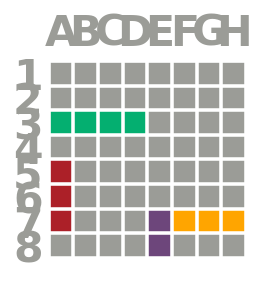

LLM Response:  no
Human Response:  no
def answer(board):
    top_half = board[:4, :]
    bottom_half = board[4:, :]
    top_ships = np.count_nonzero((top_half == 'G') | (top_half == 'R') | (top_half == 'P') | (top_half == 'O'))
    bottom_ships = np.count_nonzero((bottom_half == 'G') | (bottom_half == 'R') | (bottom_half == 'P') | (bottom_half == 'O'))
    return 'Yes' if top_ships > bottom_ships else 'No'
----------------------------------------
Question:  are there more ships (rather than less) in the bottom 4 rows? 
Board:  1


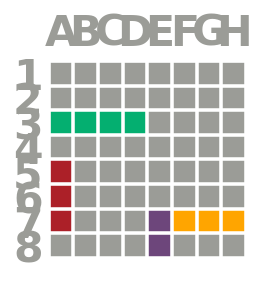

LLM Response:  yes
Human Response:  yes
def answer(board):
    top_half_ships = np.count_nonzero(board[:4, :] != 'W')
    bottom_half_ships = np.count_nonzero(board[4:, :] != 'W')
    return 'Yes' if bottom_half_ships > top_half_ships else 'No'
----------------------------------------
Question:  are there more ships on the left, compared to the right side? 
Board:  1


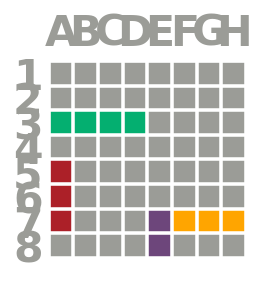

LLM Response:  yes
Human Response:  no
def answer(board):
    left_side = board[:, :4]
    right_side = board[:, 4:]
    left_ships = np.count_nonzero(left_side != 'W')
    right_ships = np.count_nonzero(right_side != 'W')
    return 'Yes' if left_ships > right_ships else 'No'
----------------------------------------
Question:  are most of the ships horizontal? 
Board:  1


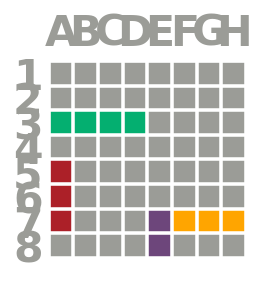

LLM Response:  no
Human Response:  no
def answer(board):
    horizontal_count = 0
    vertical_count = 0
    
    # Check for horizontal ships
    for row in board:
        for i in range(len(row) - 1):
            if row[i] != 'W' and row[i] == row[i + 1]:
                horizontal_count += 1
                break
    
    # Check for vertical ships
    for col in range(board.shape[1]):
        for row in range(board.shape[0] - 1):
            if board[row][col] != 'W' and board[row][col] == board[row + 1][col]:
                vertical_count += 1
                break
    
    return 'Yes' if horizontal_count > vertical_count else 'No'
----------------------------------------
Question:  is the orange ship vertical? 
Board:  1


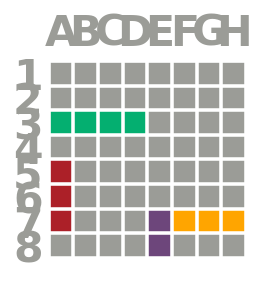

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.all(board[6, 5:8] == 'O') else 'No'
----------------------------------------
Question:  is the purple vertical? 
Board:  1


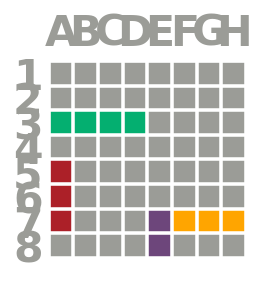

LLM Response:  yes
Human Response:  yes
def answer(board):
    purple_positions = np.argwhere(board == 'P')
    rows = purple_positions[:, 0]
    return 'Yes' if len(set(rows)) > 1 else 'No'
----------------------------------------
Question:  is the red ship on same side as the orange? 
Board:  1


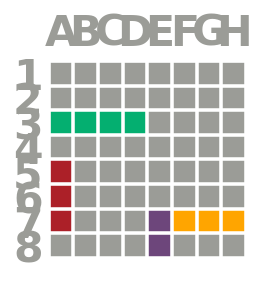

LLM Response:  no
Human Response:  no
def answer(board):
    red_positions = np.argwhere(board == 'R')
    orange_positions = np.argwhere(board == 'O')
    red_side = np.mean(red_positions[:, 1]) < board.shape[1] / 2
    orange_side = np.mean(orange_positions[:, 1]) < board.shape[1] / 2
    return 'Yes' if red_side == orange_side else 'No'
----------------------------------------
Question:  is the red ship in the top 4 rows? 
Board:  1


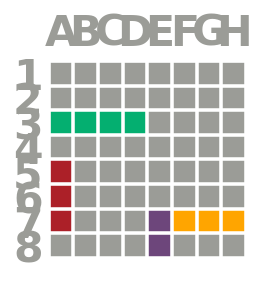

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if 'R' in board[:4, :] else 'No'
----------------------------------------
Question:  is the red ship in the 1st 4 columns from left? 
Board:  1


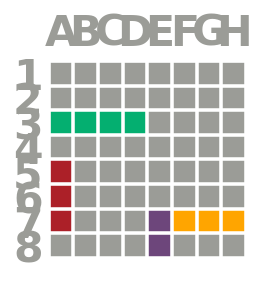

LLM Response:  yes
Human Response:  yes
def answer(board):
    red_ship_positions = np.where(board == 'R')
    return 'Yes' if np.all(red_ship_positions[1] < 4) else 'No'
----------------------------------------
Question:  are the ships more populated on the top of the board? 
Board:  4


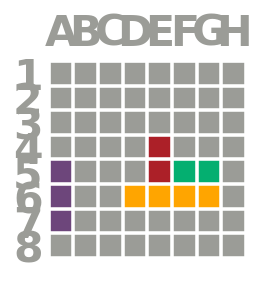

LLM Response:  no
Human Response:  no
def answer(board):
    top_half = board[:4, :]
    bottom_half = board[4:, :]
    top_count = np.count_nonzero(top_half != 'W')
    bottom_count = np.count_nonzero(bottom_half != 'W')
    return 'Yes' if top_count > bottom_count else 'No'
----------------------------------------
Question:  are they on the bottom left side? 
Board:  4


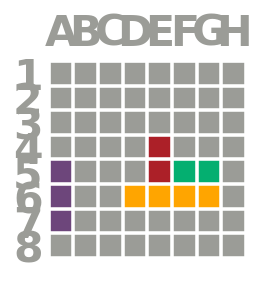

LLM Response:  yes
Human Response:  yes
def answer(board):
    bottom_left = board[4:, :4]
    return 'Yes' if np.any(np.isin(bottom_left, ['G', 'R', 'P', 'O'])) else 'No'
----------------------------------------
Question:  is the purple ship horizontal? 
Board:  4


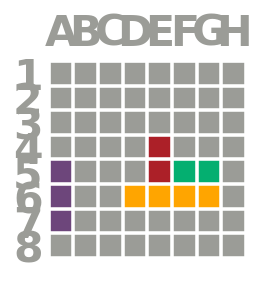

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.all(board[4:5, 0] == 'P') else 'No'
----------------------------------------
Question:  is the orange ship horizontal? 
Board:  4


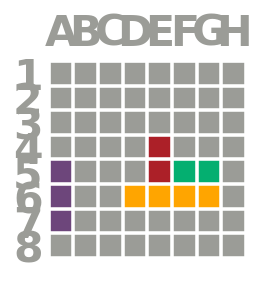

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.all(board[5, 3:7] == 'O') else 'No'
----------------------------------------
Question:  are the last ships on the columns 5-6? 
Board:  4


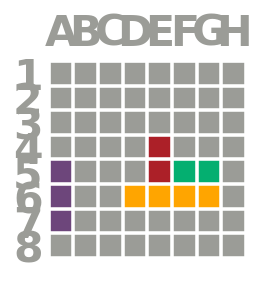

LLM Response:  yes
Human Response:  yes
def answer(board):
    columns_5_6 = board[:, 4:6]  # Columns 5 and 6 are index 4 and 5
    return 'Yes' if np.any(np.isin(columns_5_6, ['G', 'R', 'P', 'O'])) else 'No'
----------------------------------------
Question:  is the green ship horizontal? 
Board:  4


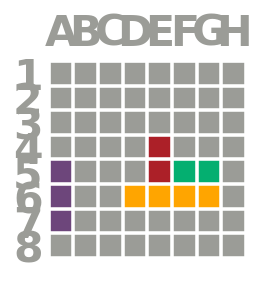

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(np.all(board == 'G', axis=1)) else 'No'
----------------------------------------
Question:  is the red ship horizontal? 
Board:  4


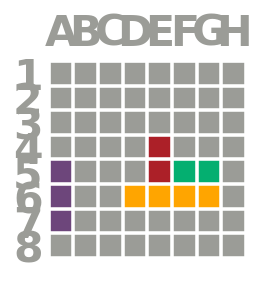

LLM Response:  no
Human Response:  yes
def answer(board):
    red_positions = np.argwhere(board == 'R')
    if len(red_positions) < 2:
        return 'No'
    return 'Yes' if red_positions[0][0] == red_positions[1][0] else 'No'
----------------------------------------
Question:  is there a ship in the top left quadrant? 
Board:  6


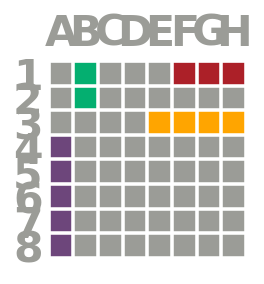

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:4, :4] != 'W') else 'No'
----------------------------------------
Question:  is there more than one ship in the top left quadrant? 
Board:  6


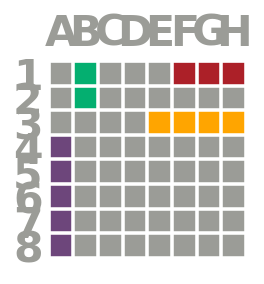

LLM Response:  yes
Human Response:  yes
def answer(board):
    top_left_quadrant = board[:4, :4]
    unique_ships = np.unique(top_left_quadrant[top_left_quadrant != 'W'])
    return 'Yes' if len(unique_ships) > 1 else 'No'
----------------------------------------
Question:  are they both horizontal and vertical? 
Board:  6


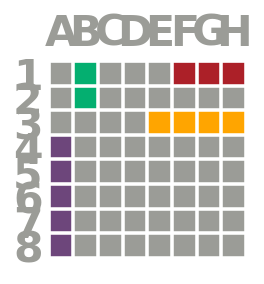

LLM Response:  no
Human Response:  no
def answer(board):
    top_left_quadrant = board[:4, :4]
    unique_ships = np.unique(top_left_quadrant[top_left_quadrant != 'W'])
    horizontal = any(np.all(row == ship) for row in top_left_quadrant for ship in unique_ships)
    vertical = any(np.all(col == ship) for col in top_left_quadrant.T for ship in unique_ships)
    return 'Yes' if horizontal and vertical else 'No'
----------------------------------------
Question:  are they both vertical? 
Board:  6


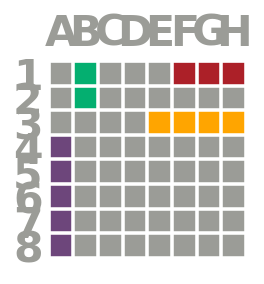

LLM Response:  no
Human Response:  yes
def answer(board):
    top_left_quadrant = board[:4, :4]
    unique_ships = np.unique(top_left_quadrant[top_left_quadrant != 'W'])
    return 'Yes' if all(np.any(top_left_quadrant == ship, axis=0).sum() > 1 for ship in unique_ships) else 'No'
----------------------------------------
Question:  are they both below row c. meaning no part of the ship goes above row c 
Board:  6


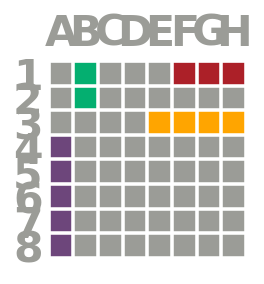

LLM Response:  no
Human Response:  no
def answer(board):
    top_left_quadrant = board[:4, :4]
    green_ship = np.any(top_left_quadrant == 'G')
    purple_ship = np.any(top_left_quadrant == 'P')
    return 'Yes' if not green_ship and not purple_ship else 'No'
----------------------------------------
Question:  is there another ship that has part of it in row c 
Board:  6


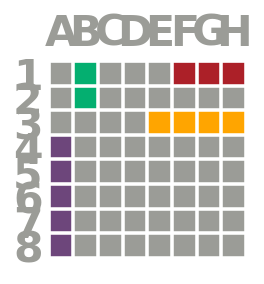

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[2] != 'W') else 'No'
----------------------------------------
Question:  is there a ship that is in the lower left quadrant? 
Board:  6


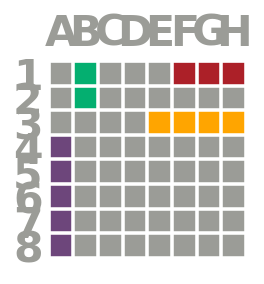

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[4:, :4] != 'W') else 'No'
----------------------------------------
Question:  is the ship in the lower left quadrant vertical? 
Board:  6


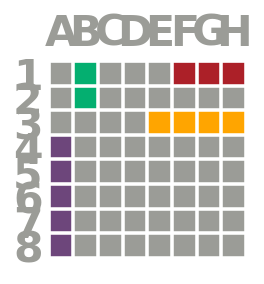

LLM Response:  yes
Human Response:  yes
def answer(board):
    lower_left_quadrant = board[4:, :4]
    ship_tiles = np.isin(lower_left_quadrant, ['G', 'R', 'P', 'O'])
    vertical_ship = np.any(np.all(ship_tiles, axis=0))
    return 'Yes' if vertical_ship else 'No'
----------------------------------------
Question:  is the ship in the lower left quadrant either in columns 1 or 2? 
Board:  6


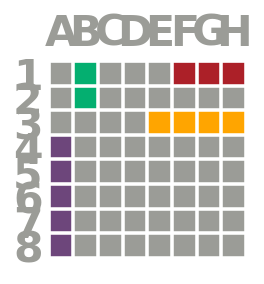

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[4:, :2] == 'P') else 'No'
----------------------------------------
Question:  is there another ship in the lower left quadrant? 
Board:  6


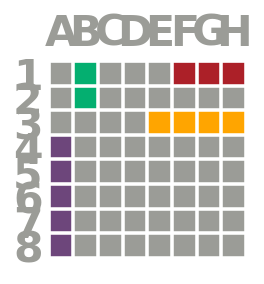

LLM Response:  yes
Human Response:  no
def answer(board):
    lower_left_quadrant = board[4:, :4]
    return 'Yes' if np.any(lower_left_quadrant == 'P') else 'No'
----------------------------------------
Question:  is there a ship in the upper left quadrant a1-d4? 
Board:  2


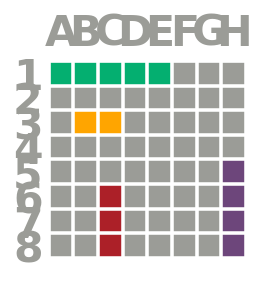

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:4, 0:4] != 'W') else 'No'
----------------------------------------
Question:  is the ship within a1-d4 verticle? 
Board:  2


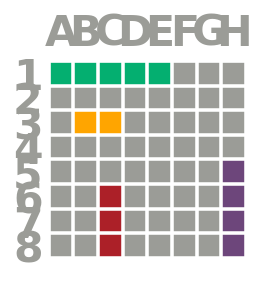

LLM Response:  no
Human Response:  no
def answer(board):
    sub_board = board[0:4, 0:4]
    for col in range(sub_board.shape[1]):
        if np.all(sub_board[:, col] == sub_board[0, col]) and sub_board[0, col] != 'W':
            return 'Yes'
    return 'No'
----------------------------------------
Question:  is there a ship in the upper left quadrant d5-a8 
Board:  2


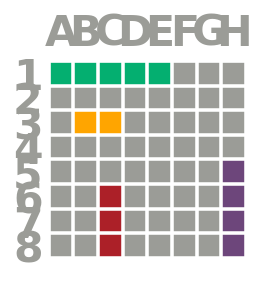

LLM Response:  yes
Human Response:  yes
def answer(board):
    sub_board = board[4:8, 0:4]  # Extract the sub-board from d5 to a8
    return 'Yes' if np.any(sub_board != 'W') else 'No'
----------------------------------------
Question:  is the ship in d5-a8 vertical? 
Board:  2


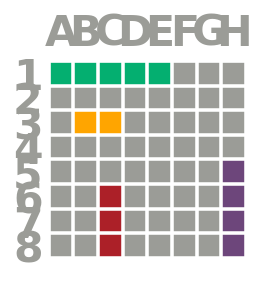

LLM Response:  no
Human Response:  no
def answer(board):
    sub_board = board[4:8, 0:4]  # Extract the sub-board for d5-a8
    for col in range(sub_board.shape[1]):
        if np.all(sub_board[:, col] == sub_board[0, col]) and sub_board[0, col] != 'W':
            return 'Yes'
    return 'No'
----------------------------------------
Question:  are they both either in a or b? 
Board:  2


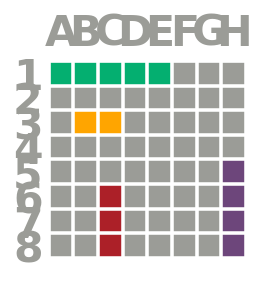

LLM Response:  no
Human Response:  no
def answer(board):
    upper_left_ship = np.any(board[0:4, 0:4] != 'W')
    lower_left_ship = np.any(board[4:8, 0:4] != 'W')
    upper_left_in_a_or_b = np.all(board[0:4, 0:2] != 'W')
    lower_left_in_a_or_b = np.all(board[4:8, 0:2] != 'W')
    return 'Yes' if upper_left_ship and lower_left_ship and upper_left_in_a_or_b and lower_left_in_a_or_b else 'No'
----------------------------------------
Question:  is there a ship in the lower left quadrant e4-h1 
Board:  2


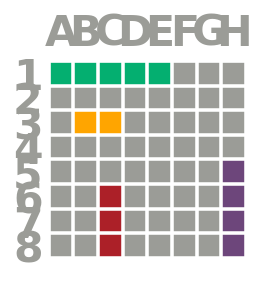

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'No' if np.all(board[0:4, 4:8] == 'W') else 'Yes'
----------------------------------------
Question:  is there a ship above c6 that is horizontal 
Board:  2


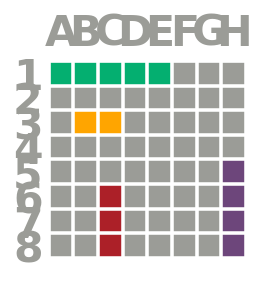

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:5, 2] == board[5, 2]) and np.any(board[5, 1:3] == board[5, 2]) else 'No'
----------------------------------------
Question:  are the last two ships on the lower half of the grid? 
Board:  2


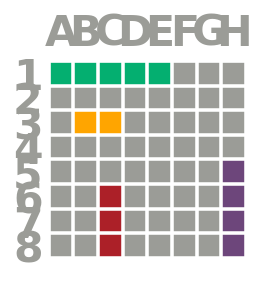

LLM Response:  yes
Human Response:  yes
def answer(board):
    lower_half = board[4:8, :]
    unique_ships = set(lower_half.flatten()) - {'W'}
    return 'Yes' if len(unique_ships) == 2 else 'No'
----------------------------------------
Question:  are they both within rows g-h 
Board:  2


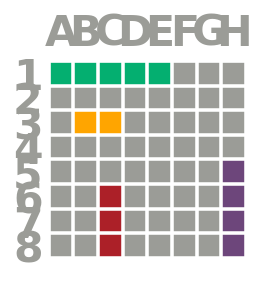

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'No' if np.any(board[4:6] != 'W') else 'Yes'
----------------------------------------
Question:  is one vertical, and the other horizontal? 
Board:  2


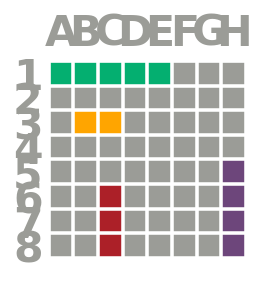

LLM Response:  no
Human Response:  no
def answer(board):
    lower_half = board[4:8, :]
    vertical_ships = any(
        (lower_half[i, j] == lower_half[i+1, j] == lower_half[i+2, j] != 'W') or
        (i < 5 and lower_half[i, j] == lower_half[i+1, j] == lower_half[i+2, j] == lower_half[i+3, j] != 'W')
        for i in range(4) for j in range(8)
    )
    horizontal_ships = any(
        (lower_half[i, j] == lower_half[i, j+1] == lower_half[i, j+2] != 'W') or
        (j < 5 and lower_half[i, j] == lower_half[i, j+1] == lower_half[i, j+2] == lower_half[i, j+3] != 'W')
        for i in range(4) for j in range(5)
    )
    return 'Yes' if vertical_ships and horizontal_ships else 'No'
----------------------------------------
Question:  are more ships on the first 4 rows on the left? 
Board:  3


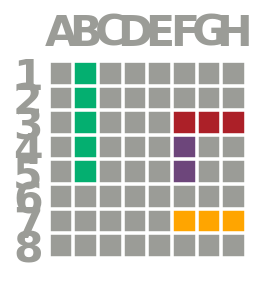

LLM Response:  no
Human Response:  no
def answer(board):
    left_half = board[:4, :4]
    right_half = board[:4, 4:]
    left_ships = np.count_nonzero(np.isin(left_half, ['G', 'R', 'P', 'O']))
    right_ships = np.count_nonzero(np.isin(right_half, ['G', 'R', 'P', 'O']))
    return 'Yes' if left_ships > right_ships else 'No'
----------------------------------------
Question:  are there any ships in any of the 4 columns on the right side of graph? 
Board:  3


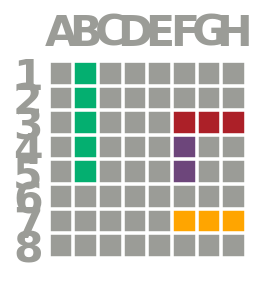

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 4:] != 'W') else 'No'
----------------------------------------
Question:  are there more than 2 ships in the four columns on the right side of graph? 
Board:  3


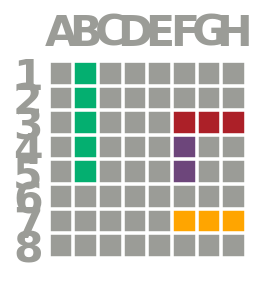

LLM Response:  yes
Human Response:  yes
def answer(board):
    right_side = board[:, 4:]
    unique_ships = np.unique(right_side[right_side != 'W'])
    return 'Yes' if len(unique_ships) > 2 else 'No'
----------------------------------------
Question:  are the ships on the four columns on the right side, all veritical? 
Board:  3


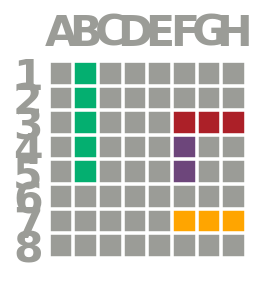

LLM Response:  no
Human Response:  no
def answer(board):
    right_columns = board[:, 4:]
    for col in range(right_columns.shape[1]):
        ship_tiles = np.unique(right_columns[:, col])
        ship_tiles = ship_tiles[ship_tiles != 'W']
        if len(ship_tiles) > 1:
            return 'No'
    return 'Yes'
----------------------------------------
Question:  are the ships in the 4 columns on the right, both horizontal and vertical? 
Board:  3


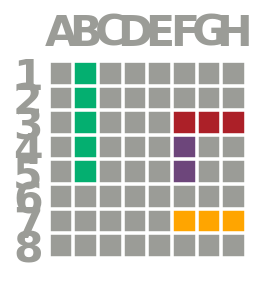

LLM Response:  yes
Human Response:  yes
def answer(board):
    right_columns = board[:, 4:]
    horizontal_ships = np.any(np.all(right_columns == right_columns[:, 0][:, None], axis=1))
    vertical_ships = np.any(np.all(right_columns == right_columns[0, :][None, :], axis=0))
    return 'Yes' if horizontal_ships and vertical_ships else 'No'
----------------------------------------
Question:  is there a ship in column 5 a through h? 
Board:  3


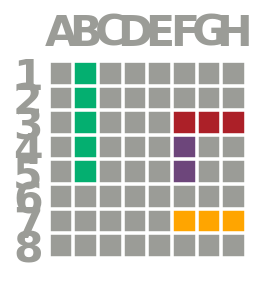

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 4] != 'W') else 'No'
----------------------------------------
Question:  is there a ship anywhere in column 6, a through h? 
Board:  3


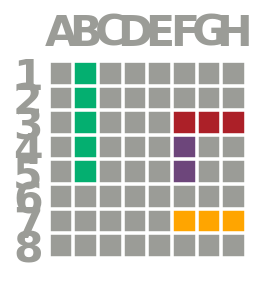

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 5] != 'W') else 'No'
----------------------------------------
Question:  bottom 4 of the quadrant (of column 6)? 
Board:  3


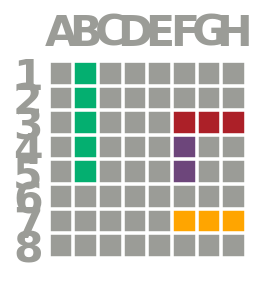

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[4:8, 5] != 'W') else 'No'
----------------------------------------
Question:  are there any more ships in columns 5-8, bottom quadrant? 
Board:  3


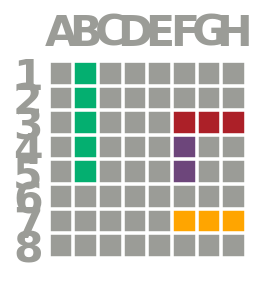

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[4:8, 4:8] != 'W') else 'No'
----------------------------------------
Question:  are there any ships in columns 1-4, bottom left quadrant? 
Board:  3


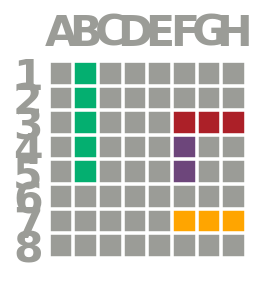

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[4:8, 0:4] != 'W') else 'No'
----------------------------------------
Question:  are there any corner squares? 
Board:  3


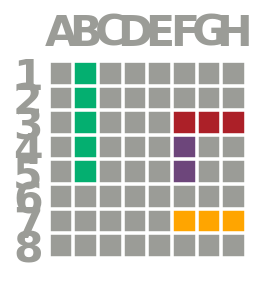

LLM Response:  no
Human Response:  yes
def answer(board):
    corners = [(0, 0), (0, 7), (7, 0), (7, 7)]
    return 'Yes' if any(board[r, c] != 'W' for r, c in corners) else 'No'
----------------------------------------
Question:  click yes if top and no if bottom 
Board:  3


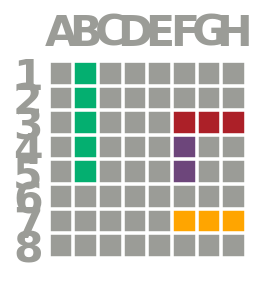

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if board[0, 0] != 'W' or board[0, -1] != 'W' else 'No'
----------------------------------------
Question:  are there any on the even numbered files that are also even numbered letters 
Board:  3


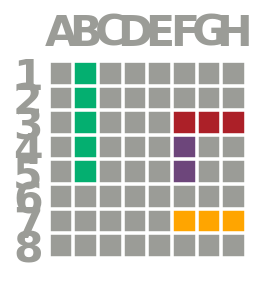

LLM Response:  yes
Human Response:  yes
def answer(board):
    even_rows = board[1::2]
    even_cols = even_rows[:, 1::2]
    return 'Yes' if np.any(even_cols != 'W') else 'No'
----------------------------------------
Question:  click yes if horizontal, no if vertical 
Board:  3


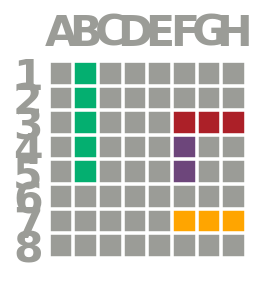

LLM Response:  no
Human Response:  no
def answer(board):
    return 'No' if np.any(board[:, 1] == 'G') else 'Yes'
----------------------------------------
Question:  click yes if there are any tiles to the left of the ship, no if to the left of the ship 
Board:  3


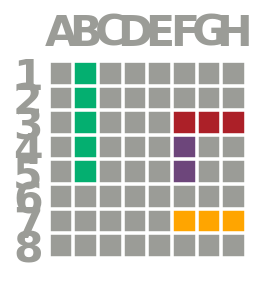

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, :-1] == 'W') else 'No'
----------------------------------------
Question:  click yes if the tiles are b-f, no if they are g-h 
Board:  3


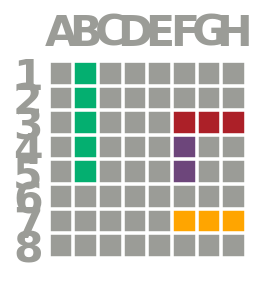

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 1:6] != 'W') else 'No'
----------------------------------------
Question:  are there any on the c file 
Board:  3


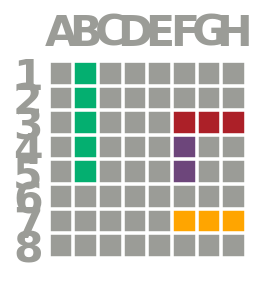

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 2] != 'W') else 'No'
----------------------------------------
Question:  click yes if on the f file, no if on the a file 
Board:  3


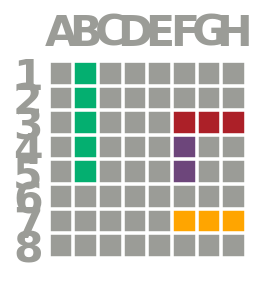

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 5] != 'W') else 'No'
----------------------------------------
Question:  (huh?? first you're wrong about the corners, now this??) are there any on the g file 
Board:  3


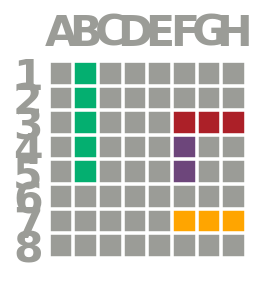

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 6] != 'W') else 'No'
----------------------------------------
Question:  is this vertical? 
Board:  3


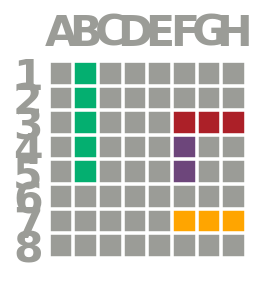

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 2] == 'G') else 'No'
----------------------------------------
Question:  is green horizontal? 
Board:  3


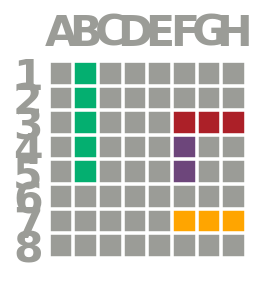

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(np.all(board == 'G', axis=1)) else 'No'
----------------------------------------
Question:  is red horizontal? 
Board:  3


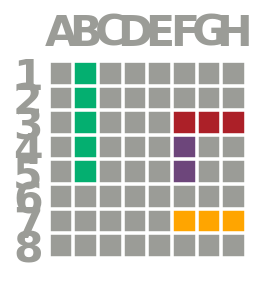

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.all(board[2, 5:8] == 'R') else 'No'
----------------------------------------
Question:  is last ship on column 1? 
Board:  3


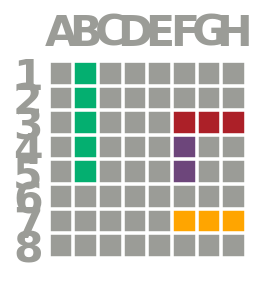

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 0] != 'W') else 'No'
----------------------------------------
Question:  column 8? 
Board:  3


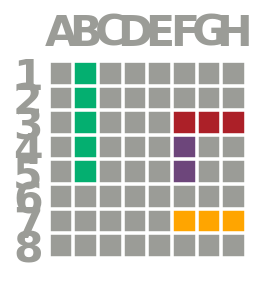

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 7] != 'W') else 'No'
----------------------------------------
Question:  4? 
Board:  3


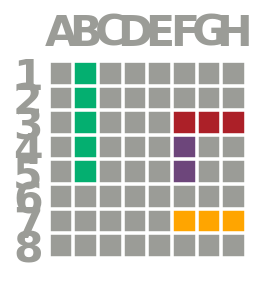

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 3] != 'W') else 'No'
----------------------------------------
Question:  7? 
Board:  3


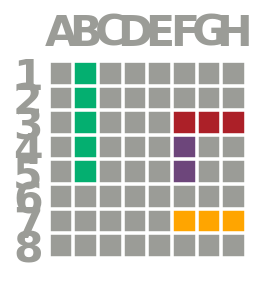

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if 'O' in board[:, 6] else 'No'
----------------------------------------
Question:  3? 
Board:  3


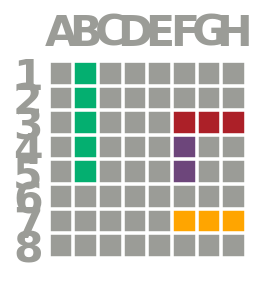

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if 'O' in board[:, 2] else 'No'
----------------------------------------
Question:  lol 6? 
Board:  3


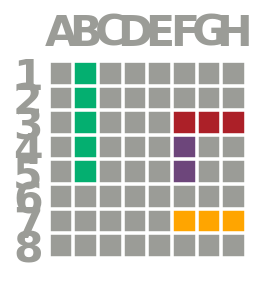

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if 'O' in board[:, 5] else 'No'
----------------------------------------
Question:  should i shoot up? 
Board:  3


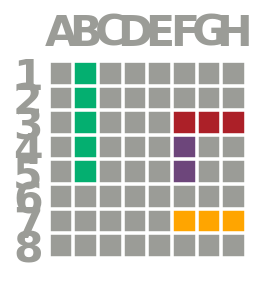

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'No'
----------------------------------------
Question:  are there any on the b file? 
Board:  5


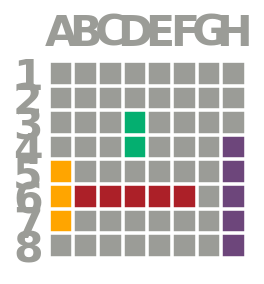

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 1] != 'W') else 'No'
----------------------------------------
Question:  are there any on the c or d file 
Board:  5


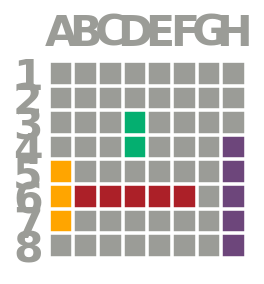

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 2:4] != 'W') else 'No'
----------------------------------------
Question:  click yes if they are 1-4, no if they are 5-8 
Board:  5


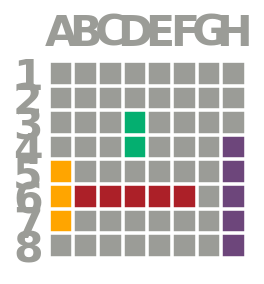

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:4, :] != 'W') else 'No'
----------------------------------------
Question:  click yes if f-h, no if a-b 
Board:  5


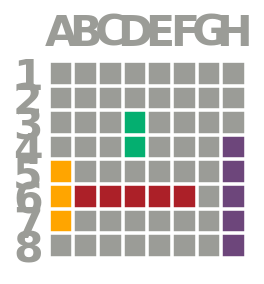

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 5:8] != 'W') else 'No'
----------------------------------------
Question:  click yes if e-h, no if a-d 
Board:  5


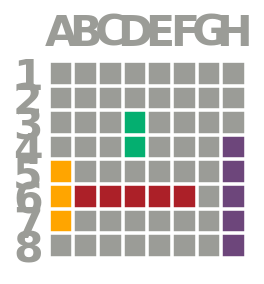

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 4:] != 'W') else 'No'
----------------------------------------
Question:  click yes if vertical, no if horizontal 
Board:  5


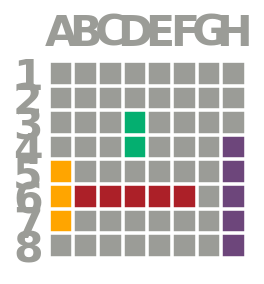

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(np.all(board == 'P', axis=0)) else 'No'
----------------------------------------
Question:  should i fire up on the board? 
Board:  2


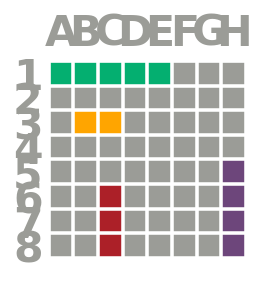

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'No'
----------------------------------------
Question:  is the red ship horizontal? 
Board:  2


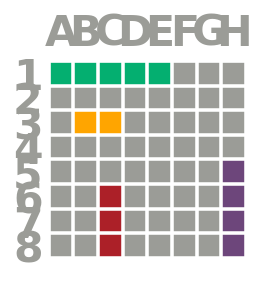

LLM Response:  no
Human Response:  yes
def answer(board):
    red_positions = np.argwhere(board == 'R')
    if len(red_positions) < 2:
        return 'No'
    return 'Yes' if red_positions[0][0] == red_positions[1][0] else 'No'
----------------------------------------
Question:  should i continue to fire up on the board? 
Board:  2


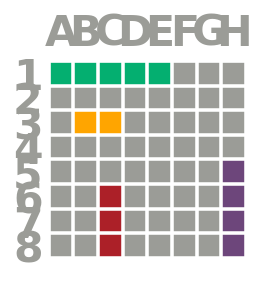

LLM Response:  no
Human Response:  no
def answer(board):
    return 'No'
----------------------------------------
Question:  is the blue ship horizontal? 
Board:  2


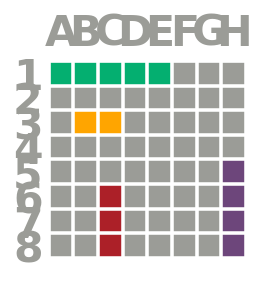

LLM Response:  no
Human Response:  no
def answer(board):
    return "No"
----------------------------------------
Question:  sorry about that, i didn't realize the blue was water. should i fire up on purple? 
Board:  2


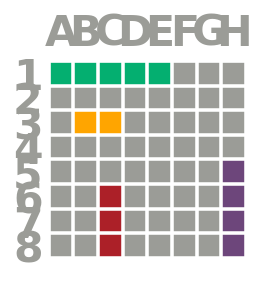

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board == 'P') else 'No'
----------------------------------------
Question:  should i fire up or down on green? 
Board:  2


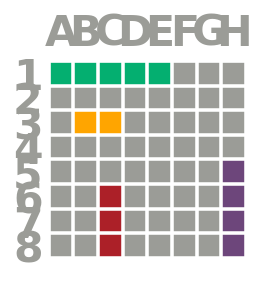

LLM Response:  no
Human Response:  yes
def answer(board):
    green_positions = np.argwhere(board == 'G')
    if len(green_positions) == 0:
        return 'No'
    min_row = np.min(green_positions[:, 0])
    max_row = np.max(green_positions[:, 0])
    if min_row == max_row:
        return 'No'
    return 'Yes' if min_row > 0 else 'No'
----------------------------------------
Question:  is the last ship in the middle? 
Board:  2


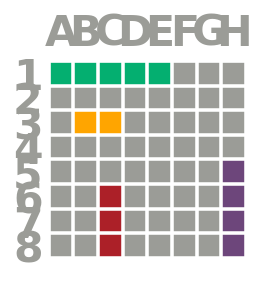

LLM Response:  yes
Human Response:  no
def answer(board):
    middle_rows = [3, 4, 5, 6]
    middle_cols = [2, 3, 4, 5]
    for row in middle_rows:
        for col in middle_cols:
            if board[row-1, col-1] in ['G', 'R', 'P', 'O']:
                return 'Yes'
    return 'No'
----------------------------------------
Question:  is it in a corner? 
Board:  2


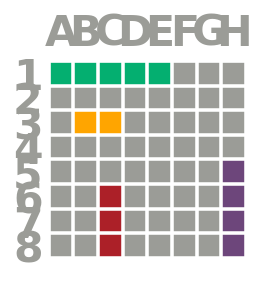

LLM Response:  yes
Human Response:  no
def answer(board):
    corners = [(0, 0), (0, 7), (7, 0), (7, 7)]
    for corner in corners:
        if board[corner] in ['G', 'R', 'P', 'O']:
            return 'Yes'
    return 'No'
----------------------------------------
Question:  is it on the top or the bottom side of the board? 
Board:  2


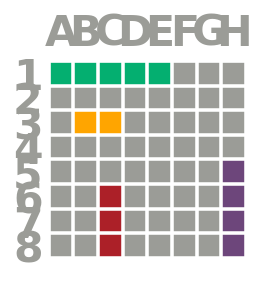

LLM Response:  yes
Human Response:  no
def answer(board):
    top_side = np.any(board[0, :] != 'W')
    bottom_side = np.any(board[-1, :] != 'W')
    return 'Yes' if top_side or bottom_side else 'No'
----------------------------------------
Question:  is there a ship between rows a1-4 and d1-4? 
Board:  4


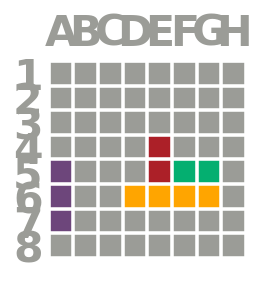

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[0:4, 0:4] != 'W') else 'No'
----------------------------------------
Question:  is there a ship between rows a5-8, and d5-8 
Board:  4


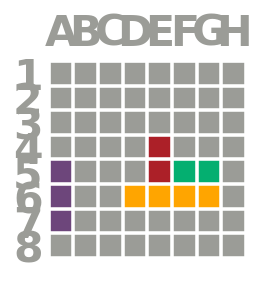

LLM Response:  yes
Human Response:  yes
def answer(board):
    sub_board = board[4:8, 0:4]  # Rows 5-8, Columns A-D
    return 'Yes' if np.any(sub_board != 'W') else 'No'
----------------------------------------
Question:  is there more than one between rows a5-8 and d5-8? 
Board:  4


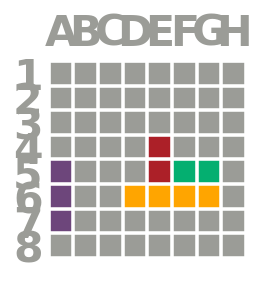

LLM Response:  yes
Human Response:  no
def answer(board):
    sub_board = board[4:8, 0:4]  # Rows 5-8, Columns A-D
    unique_ships = set(sub_board.flatten()) - {'W'}
    return 'Yes' if len(unique_ships) > 1 else 'No'
----------------------------------------
Question:  is the one between rows a5-8 and d5-8 vertical? 
Board:  4


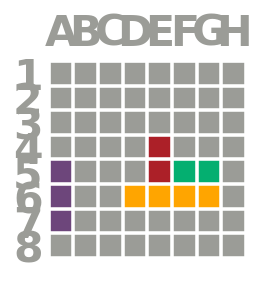

LLM Response:  yes
Human Response:  yes
def answer(board):
    # Check if there is a vertical ship between columns A and D in rows 5 to 8
    for col in range(0, 4):  # Columns A to D
        if board[4:8, col].tolist().count('W') < 4:  # If there's any ship part in the column
            return 'Yes'
    return 'No'
----------------------------------------
Question:  is there a ship between rows e1-4 and h1-4? 
Board:  4


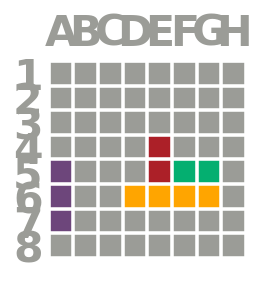

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[0:4, 4:8] != 'W') else 'No'
----------------------------------------
Question:  is there more than one ship between rows e1-4 and h1-4? 
Board:  4


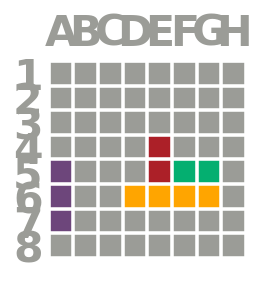

LLM Response:  no
Human Response:  yes
def answer(board):
    sub_board = board[0:4, 4:8]
    unique_ships = np.unique(sub_board[sub_board != 'W'])
    return 'Yes' if len(unique_ships) > 1 else 'No'
----------------------------------------
Question:  are they both orientated the same way? 
Board:  4


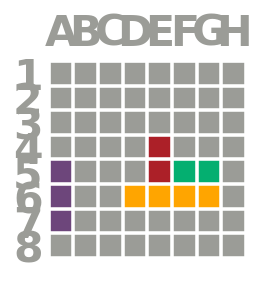

LLM Response:  yes
Human Response:  no
def answer(board):
    ship1 = board[3:4, 4:8]
    ship2 = board[4:5, 4:8]
    ship1_orientation = 'horizontal' if np.any(ship1 == 'R') else 'vertical'
    ship2_orientation = 'horizontal' if np.any(ship2 == 'R') else 'vertical'
    return 'Yes' if ship1_orientation == ship2_orientation else 'No'
----------------------------------------
Question:  is there a ship between e5-8 and h5-8? 
Board:  4


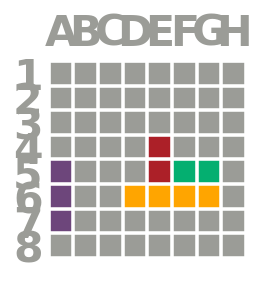

LLM Response:  yes
Human Response:  yes
def answer(board):
    sub_board = board[4:8, 4:8]  # E5-8 to H5-8
    return 'Yes' if np.any(sub_board != 'W') else 'No'
----------------------------------------
Question:  is there ship that is vertical in rows a-d in columns 7 or 8? 
Board:  4


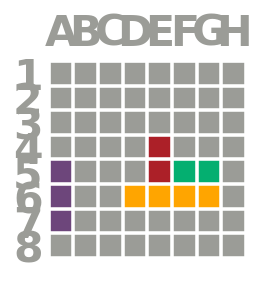

LLM Response:  no
Human Response:  (answer timed out)
def answer(board):
    return 'Yes' if np.any(board[:4, 6:8] != 'W') and np.all(board[:4, 6:8] == board[0, 6:8]) else 'No'
----------------------------------------
Question:  is the ship that is vertical in rows a-d in columns 7 or 8? 
Board:  4


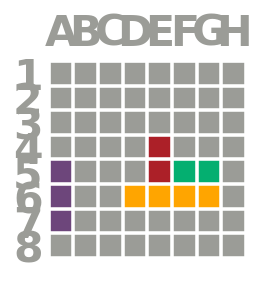

LLM Response:  no
Human Response:  no
def answer(board):
    vertical_ship = np.any(board[0:4, 6] != 'W') or np.any(board[0:4, 7] != 'W')
    return 'Yes' if vertical_ship else 'No'
----------------------------------------
Question:  is there any ships on even number columns? 
Board:  1


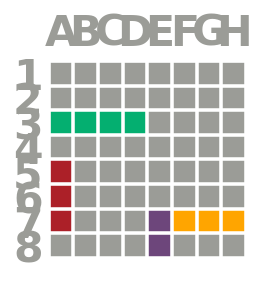

LLM Response:  yes
Human Response:  (captain timed out)
def answer(board):
    return 'Yes' if np.any(board[:, [1, 3, 5, 7]] != 'W') else 'No'
----------------------------------------
Question:  is there any ships on even number columns? 
Board:  1


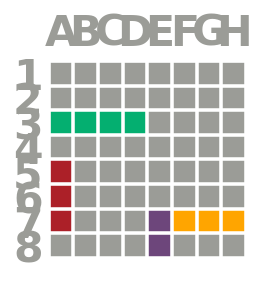

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, [1, 3, 5, 7]] != 'W') else 'No'
----------------------------------------
Question:  is there any ships on every 2nd letter? 
Board:  1


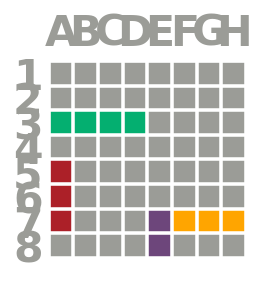

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 1::2] != 'W') else 'No'
----------------------------------------
Question:  are they horizontal? 
Board:  1


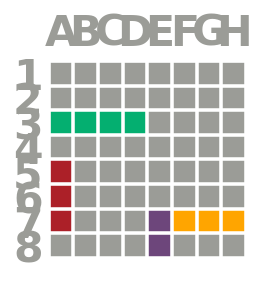

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if any(np.all(board[i, j:j+2] == board[i, j]) for i in range(8) for j in range(7)) else 'No'
----------------------------------------
Question:  are they on edges? 
Board:  1


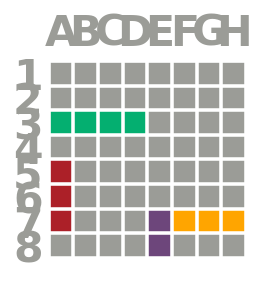

LLM Response:  yes
Human Response:  yes
def answer(board):
    edge_positions = np.concatenate((board[0, :], board[-1, :], board[:, 0], board[:, -1]))
    return 'Yes' if np.any(np.isin(edge_positions, ['G', 'R', 'P', 'O'])) else 'No'
----------------------------------------
Question:  answer yes if i should aim directly above or no if i should aim more to the left 
Board:  1


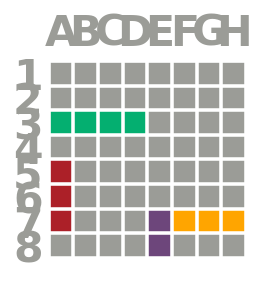

LLM Response:  no
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:6, 6] != 'W') else 'No'
----------------------------------------
Question:  say yes if i should aim below or no if i should aim above 
Board:  1


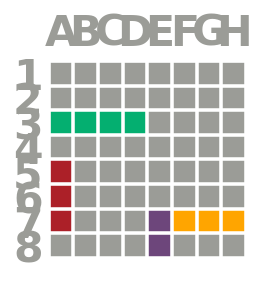

LLM Response:  no
Human Response:  yes
def answer(board):
    return 'yes' if np.any(board[4:, 2] == 'R') else 'no'
----------------------------------------
Question:  is it on f? 
Board:  1


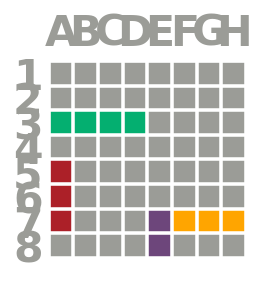

LLM Response:  yes
Human Response:  no
def answer(board):
    return 'Yes' if np.any(board[:, 5] != 'W') else 'No'
----------------------------------------
Question:  is it on c or g 
Board:  1


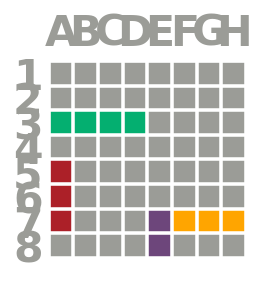

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, [2, 6]] != 'W') else 'No'
----------------------------------------
Question:  are they on the 8 file or the 1 file? 
Board:  1


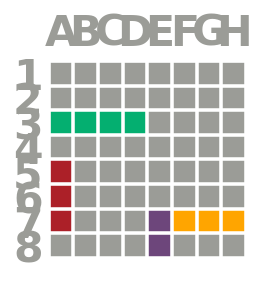

LLM Response:  yes
Human Response:  yes
def answer(board):
    return 'Yes' if np.any(board[:, 0] != 'W') or np.any(board[:, 7] != 'W') else 'No'
----------------------------------------


In [ ]:
from ast import literal_eval
from pathlib import Path

for cache_key in code_spotter_accuracy[1]:
    cache_file = Path("./cache") / "CodeSpotterModel" / f"{cache_key[0]}.txt"
    if cache_file.exists():
        cache_dict = literal_eval(cache_file.read_text())
        question = cache_key[0].replace("_", " ")[:-1]
        board = cache_key[0][-1]
        print("Question: ", question)
        print("Board: ", board)
        display(Board.from_trial_id(board, "prolific_contexts").to_figure(2))
        print("LLM Response: ", cache_key[1][0])
        print("Human Response: ", cache_key[1][1])
        print(cache_dict["code"])
        print("-"*40)


In [ ]:
direct_spotter_accuracy = benchmark_on_rounds(df, rounds, DirectSpotterModel, False, 10, 15)
direct_spotter_accuracy

 75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

Error with decision id 49.0


100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


0.38461538461538464